### _imports_

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import time
import os
import re
import json

from collections import Counter

# 1. Meduza

_Я не стал парсить текст "ххх минут назад", чтобы построить точную гистограмму по времени, потому что это не совсем тема данной работы (а похожую задачу мы уже решали в_ [_прошлом ДЗ_](https://github.com/rklepov/data_mining_course2/blob/homework/07_xml_and_visualization/Hw/Homework_8.ipynb) _- возраст живатоных)._

In [2]:
response = requests.get('https://meduza.io/')
soup = BeautifulSoup(response.text, 'html.parser')

In [3]:
when = pd.DataFrame(columns=['when', 'count'],
                    data=Counter([ time.text for time in soup.find_all('time', {'class': 'Timestamp-root'}) ]).most_common())

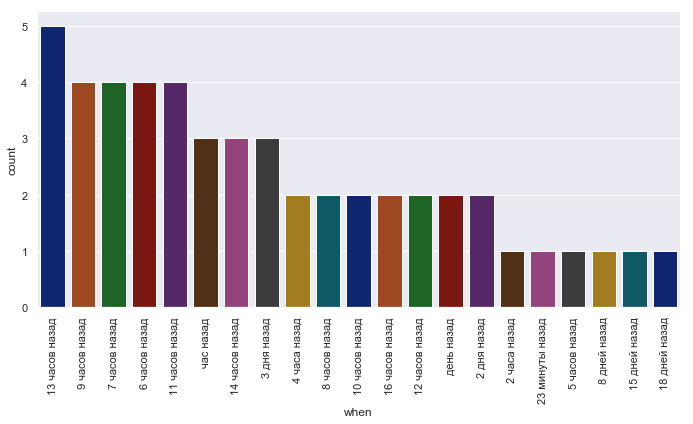

In [4]:
sns.set()
g = sns.catplot(x='when', y='count', data=when, kind='bar', height=5, aspect=2, palette='dark')
g.set_xticklabels(rotation = 90);

# 2. StarWars

_Данная задача плохо воспроизводится, потому что Яндекс банит(_

In [5]:
# обходим блокировку через Тор
import socks
import socket

# !pip install fake_useragent
from fake_useragent import UserAgent

socks.set_default_proxy(socks.SOCKS5, "localhost", 9150)
if not socket.socket is socks.socksocket: 
    _socket = socket.socket
    socket.socket = socks.socksocket

ua = UserAgent()

# torrc
# MaxCircuitDirtiness 10

In [6]:
os.makedirs('StarWars', exist_ok=True)

In [7]:
def get_sw_poster_previews(page):
    headers = {'User-Agent' : ua.random}
    response = requests.get('https://www.kinopoisk.ru/film/718223/posters/page/{}/'.format(page), headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    return [ img for img in soup.find_all('img', {'src' : True}) if 'poster' in img.attrs['src'] ]

In [8]:
img_previews = list(get_sw_poster_previews(1))
img_previews.extend(get_sw_poster_previews(2))
print(len(img_previews))

85


In [9]:
def get_sw_poster_img(url, attempt = 20):
#     print(url)
    headers = {'User-Agent' : ua.random}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    img = soup.find('img', {'id' : 'image', 'onclick' : True})
    if img is None and 0 < attempt - 1:
        time.sleep(1 + np.random.random())
        return get_sw_poster_img(url, attempt - 1)
#     print(img)
    return img

In [ ]:
images = [ get_sw_poster_img('https://www.kinopoisk.ru{}'.format(img.parent['href'])) 
              for img in img_previews if 'picture' in img.parent['href'] ]

In [11]:
len([ img['src'] for img in images if not img is None ])

83

In [12]:
def save_sw_poster(poster_url, attempts = 10):
    poster = requests.get(poster_url, headers=headers)
    if 200 != poster.status_code and 0 < attempts - 1:
        time.sleep(1+np.random.random())
        return save_sw_poster(poster_url, attempts - 1)
    with open('{}/{}'.format('StarWars', poster_url.split('/')[-1]), 'wb') as poster_fd:
        poster_fd.write(poster.content)

In [ ]:
for poster_url in [ img['src'] for img in images if not img is None ]:
    headers = {'User-Agent' : ua.random}
#     print(poster_url)
    save_sw_poster(poster_url)

![](StarWars/kinopoisk.ru-Star-Wars_3A-Episode-VIII-The-Last-Jedi-3061146.jpg)

# 3. auto.ru

In [14]:
# auto.ru наоборот не работает черех proxy, требует принять какое-то соглашение
socket.socket = _socket

In [15]:
headers = {'User-Agent' : ua.random}
response = requests.get('https://auto.ru/', headers=headers)
soup = BeautifulSoup(response.content.decode('utf-8'), 'html.parser')

In [16]:
items = soup.find_all('a', {'class' : 'IndexMarks__item'})
names = np.array([ item.find('div', {'class' : 'IndexMarks__item-name'}).string for item in items ])
counts = np.array([ int(item.find('div', {'class' : 'IndexMarks__item-count'}).text) for item in items ])
sorted_ix = counts.argsort()[::-1]

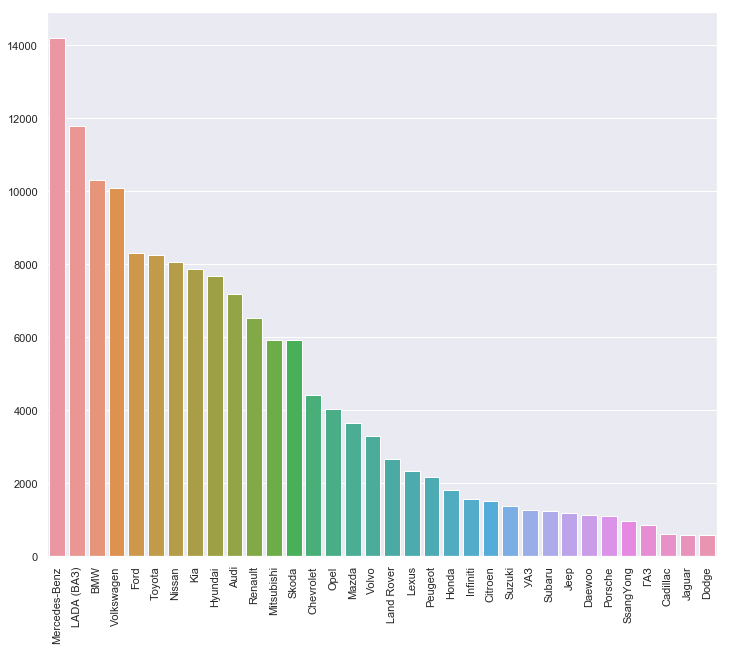

In [17]:
sns.set(rc={'figure.figsize':(12,10)})
g = sns.barplot(x=names[sorted_ix], y=counts[sorted_ix])
g.set_xticklabels(names[sorted_ix], rotation = 90);

# 4. Kaggle

In [18]:
response = requests.get('https://www.kaggle.com/competitions?sortBy=prize&group=general&page=1&pageSize=100')
soup = BeautifulSoup(response.text, 'html.parser')

In [19]:
# сайт динамический, данные запрятаны в json (смотрим только начальную страницу)
json_text = re.search(r'[^(]*\(({.*})\)', soup.find_all('script')[-6].string)

In [20]:
json_competitions = json.loads(json_text.groups(0)[0])

In [21]:
competitions = {'competitionTitle' : [], 'rewardDisplay' : [], 'totalTeams' : [], 'competitionDescription' : []}

for competition in json_competitions['pagedCompetitionGroup']['competitions']:
    for k in competitions.keys():
        competitions[k].append(competition[k])

competitionTitle = competitions.pop('competitionTitle')
competitions_df = pd.DataFrame(data=competitions, index=competitionTitle)
competitions_df['rewardDisplay'] = competitions_df['rewardDisplay'].apply(lambda s: int(s[1::].replace(',','')))
competitions_df.sort_values('totalTeams', ascending=False, inplace=True)
competitions_df

,rewardDisplay,totalTeams,competitionDescription
Zillow Prize: Zillow’s Home Value Prediction (Zestimate),1200000,3779,Can you improve the algorithm that changed the...
2018 Data Science Bowl,100000,3634,Find the nuclei in divergent images to advance...
TGS Salt Identification Challenge,100000,3234,Segment salt deposits beneath the Earth's surface
Mercari Price Suggestion Challenge,100000,2384,Can you automatically suggest product prices t...
The Nature Conservancy Fisheries Monitoring,150000,2293,Can you detect and classify species of fish?
Springleaf Marketing Response,100000,2226,Determine whether to send a direct mail piece ...
Two Sigma Financial Modeling Challenge,100000,2070,Can you uncover predictive value in an uncerta...
Data Science Bowl 2017,1000000,1972,Can you improve lung cancer detection?
Two Sigma: Using News to Predict Stock Movements,100000,1606,Use news analytics to predict stock price perf...
Heritage Health Prize,500000,1353,Identify patients who will be admitted to a ho...


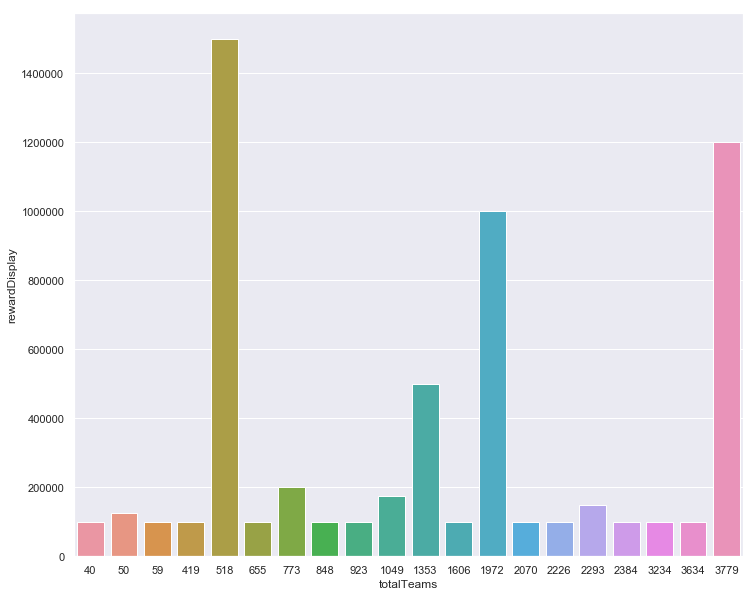

In [22]:
sns.set(rc={'figure.figsize':(12,10)})
sns.barplot(x = 'totalTeams', y = 'rewardDisplay', data=competitions_df);